## Load libraries

In [58]:
# Add root project directory to path
import sys
sys.path.append("../")

import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import time
from collections import defaultdict
from pathlib import Path

from diffnet.dataset_loader import *
from diffnet.diffnet import *

## Check GPU status

In [59]:
!nvidia-smi

Thu May 26 16:04:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:09:00.0 Off |                  N/A |
| 35%   37C    P8    21W / 260W |     15MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:0A:00.0 Off |                  N/A |
| 35%   

In [60]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] ="1"

tf.config.list_physical_devices("GPU")

# allocate as small memory as possible
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
session = tf.compat.v1.Session(config=config)

## Load input file

In [74]:
FEATURE_INPUT_FILES = ["../data/features/pormake_geo+gridhist_50.txt", "../data/features/tobacco_geo+gridhist_50.txt"]
LABEL_INPUT_FILES = ["../data/labels/pormake_adsorption_isotherm_ch4.txt", "../data/labels/tobacco_adsorption_isotherm_ch4.txt"]

f_input_df = pd.read_csv(FEATURE_INPUT_FILES[0], sep="\s+", index_col=0)
l_input_df = pd.read_csv(LABEL_INPUT_FILES[0], sep="\s+", index_col=0, header=None)

for i in range(len(FEATURE_INPUT_FILES)-1):
    idx = i+1
    
    try:
        f_df = pd.read_csv(FEATURE_INPUT_FILES[idx], sep="\s+", index_col=0)
        l_df = pd.read_csv(LABEL_INPUT_FILES[idx], sep="\s+", index_col=0, header=None)

        f_input_df = pd.concat([f_input_df, f_df])
        l_input_df = pd.concat([l_input_df, l_df])
    
    except:
        continue
    
f_input_df = f_input_df.sample(frac=1)

In [75]:
## normalize geometric features
geo_cols = f_input_df.columns[:5]
geo_df = f_input_df[:][geo_cols]

max_v = [60, 60, 4000, 10000, 1]
    
f_input_df[:][geo_cols] = f_input_df[:][geo_cols] / max_v

In [76]:
f_input_df.head()

,LCD,PLD,Vol_ASA,Grav_ASA,Void_fraction,0.0,0.02,0.04,0.06,0.08,...,0.8,0.82,0.84,0.86,0.88,0.9,0.92,0.94,0.96,0.98
MOF,,,,,,,,,,,,,,,,,,,,,
bbc+N218+N514+E192+E67+E210,0.312735,0.267591,0.460072,0.595613,0.63358,0.0,0.0,0.0,0.0,0.0,...,0.001502,0.001568,0.001101,0.001435,0.001368,0.001001,0.001134,0.001235,0.000934,0.341041
unj+N237+E175,0.268162,0.205742,0.476590,0.417900,0.58442,0.0,0.0,0.0,0.0,0.0,...,0.001478,0.001642,0.001724,0.001067,0.000493,0.001642,0.001314,0.001314,0.001314,0.378571
mof_4628,0.153757,0.126770,0.781615,0.462217,0.37194,0.0,0.0,0.0,0.0,0.0,...,0.002874,0.001868,0.001437,0.003017,0.002299,0.001868,0.002011,0.002730,0.001580,0.577011
soj+N356+E224,0.190451,0.136822,0.572725,0.436973,0.38420,0.0,0.0,0.0,0.0,0.0,...,0.001500,0.002015,0.001415,0.001586,0.001415,0.002186,0.001286,0.001543,0.001543,0.584019
yff+N206+E70,0.260347,0.173679,0.555705,0.327200,0.49666,0.0,0.0,0.0,0.0,0.0,...,0.001668,0.001919,0.001835,0.001251,0.001460,0.001418,0.001168,0.001710,0.001627,0.454913


In [77]:
## normalize labels
# 1: 1bar, 2: 2bar, 3: 5.8bar, 4: 10bar, 5: 15bar, 6: 20bar, 7: 30bar, 8:40 bar, 9: 50bar, 10: 60bar, 11:65bar, 12: 80bar, 13: 90bar, 14: 100bar
# (low p) 1 : 0.25bar, 2:, 0.5bar, 3 : 0.75bar / else is not meaningful
l_data = l_input_df[:][14]

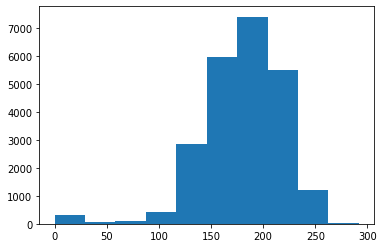

In [78]:
plt.hist(l_data)
plt.show()

In [79]:
print(np.max(l_data))
print(np.min(l_data))

291.813232
0.0


In [80]:
max_v = 300
min_v = 0

In [81]:
## normalize data
l_data = (l_data - min_v) / (max_v - min_v)

In [82]:
f_data = f_input_df.copy()

## Prediction

In [83]:
# Plz be careful with pressure.
prefix = "../checkpoint/source_geo+gridhist/CH4_pm+tb_ai_100bar/"

raw_path = prefix

# load test data used in the training
with open(f"{raw_path}/test_data.pickle", "rb") as f:
    test_data = pickle.load(f)

# load save weights
save_weights_path = str(list(Path(raw_path).glob("*.h5"))[0])

In [84]:
print("test data : {}".format(len(test_data)))

test data : 4769


In [85]:
dataloader = DataLoader()

In [86]:
test_f_data, test_l_data = dataloader.arrange_data(f_data, l_data, test_data)

test_dataset = dataloader.make_dataset(np.array(test_f_data), np.array(test_l_data),
                           batch_size=len(test_l_data), shuffle=False, repeat=False)

test_dataset = test_dataset.batch(len(test_l_data))

In [87]:
# necessary function
def cal_mse(y_true, y_pred):
    loss = tf.reduce_mean(tf.square(y_true-y_pred))
    return loss

In [88]:
from sklearn.metrics import r2_score

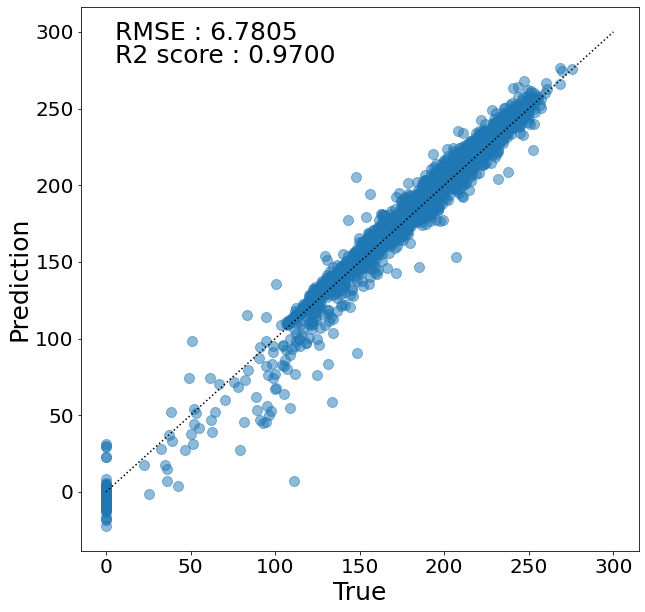

In [90]:
# load diffnet
diffnet = DiffNET(input_size=(len(f_data.columns),))
diffnet.initialize_weights()
diffnet.load_weights(save_weights_path)

# load test set data
test_y_pred = []
test_y_true = []

for x, y in test_dataset:
    _y = diffnet(x, training=False)
    test_y_pred += _y.numpy().reshape(-1).tolist()
    test_y_true += y.numpy().reshape(-1).tolist()

test_y_pred = np.array(test_y_pred)
test_y_true = np.array(test_y_true)

# convert into raw value
y_true_ = test_y_true * (max_v - min_v) + min_v
y_pred_ = test_y_pred * (max_v - min_v) + min_v

plt.figure(figsize=(10,10))
plt.scatter(y_true_, y_pred_, alpha=0.5, s=100)
plt.plot([min_v, max_v], [min_v, max_v], color="black", ls=":")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("True", fontsize=25)
plt.ylabel("Prediction", fontsize=25)
plt.show()